## Setup

In [1]:
#| code-fold: true
#| code-summary: "Show pip installs"
!pip install transformers~=4.37.2 -qq
!pip install huggingface_hub~=0.20.3 -qq
!pip install datasets~=2.16.1 -qq
!pip install accelerate -qq
!pip install plotly==5.19.0 -qq
!pip install scikit-learn==1.2 -qq

In [ ]:
#| code-fold: true
#| code-summary: "Show imports and setup"
import gc
import pandas as pd
import numpy as np
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import torch

import warnings
#warnings.filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import time

from datasets import load_dataset, Dataset
from transformers import pipeline, logging
from transformers.pipelines.pt_utils import KeyDataset
from fastcore.all import *

logging.set_verbosity_error()

#torch.set_default_device("cuda")
torch.cuda.set_device(0)
model_name = "microsoft/phi-2"

# create pipeline
pipe = pipeline(
    "text-generation",
    model=model_name,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16
)

# load dataset
dataset = load_dataset(
    "financial_phrasebank", "sentences_allagree", 
    split="train"  # note that the dataset does not have a default test split
)

## Background

In this notebook I'll use [phi-2](https://huggingface.co/microsoft/phi-2) to classify sentiment in the [`financial_phrasebank` dataset](https://huggingface.co/datasets/financial_phrasebank).

I was inspired to do so after reading [this blog post](https://huggingface.co/blog/synthetic-data-save-costs) and [this corresponding notebook](https://github.com/MoritzLaurer/synthetic-data-blog/blob/main/notebooks/synthetic_data_creation.ipynb) by Moritz Laurer as part of a fastai study group last year.

This notebook is part of [a series of blog posts](https://vishalbakshi.github.io/blog/#category=TinySentiment) for a project I'm working called **TinySentiment** where I'm experimenting with tiny models to improve their ability to classify sentiment in the `financial_phrasebank` dataset. 

This notebook establishes a baseline using phi-2.

Here are the results from this notebook:

| Prompt | Strategy | Overall Accuracy | `negative`      | `neutral`         | `positive`       |
|:-:|:-:|:-:|:-:|:-:|:-:|
| [A](#prompt-a)      | 0-Shot   | 58%               | 97% (295/303)    | 37% (520/1391)     | 86% (490/570)      |
| [B](#prompt-b)      | 0-Shot   | 81%               | 87% (264/303)    | 87% (1207/1391)    | 63% (361/570)      |
| [C](#prompt-c)      | 3-Shot   | 73%               | 96% (291/302)    | 58% (803/1390)     | <u>**98% (557/569)**</u>      |
| [D](#prompt-d)      | 6-Shot   | 74%               | <u>**99% (298/302)**</u>    | 59% (822/1387)     | 95% (542/569)      |
| [E](#prompt-e)      | 6-Shot   | 87%               | 98% (296/302)    | 82% (1131/1387)    | 94% (537/569)      |
| [F](#prompt-f)      | 6-Shot   | 84%               | <u>**99% (298/302)**</u>    | 77% (1069/1387)    | 95% (538/569)      |
| [G](#prompt-g)      | 6-Shot   | 84%               | 98% (295/302)    | 76% (1059/1387)    | 96% (546/569)      |
| [H](#prompt-h)      | 6-Shot   | 91%               | 93% (280/302)    | 88% (1219/1387)    | 96% (548/569)      |
| [I](#prompt-i)      | 14-Shot  | 89%               | 73% (221/302)    | <u>**99% (1368/1379)**</u>    | 71% (406/569)      |
| [J](#prompt-j)      | 20-Shot  | 91%               | 80% (238/299)    | 97% (1340/1379)    | 82% (466/566)      |
| [K](#prompt-k)      | 6-Shot   | 91%               | 80% (241/302)    | 95% (1318/1387)    | 89% (505/569)      |
| [L](#prompt-l)      | 6-Shot   | 90%               | 81% (246/302)    | 92% (1276/1387)    | 91% (515/569)      |
| [M](#prompt-m)      | 6-Shot   | <u>**92%**</u>               | 88% (267/302)    | 94% (1299/1387)    | 90% (510/569)      |
| [N](#prompt-n)      | 3-Shot   | 91%               | 78% (235/302)    | 95% (1320/1390)    | 89% (504/569)      |
| [O](#prompt-o)      | 3-Shot   | 91%               | 78% (237/302)    | 96% (1333/1390)    | 85% (484/569)      |

## Prompt Engineering

I'll follow the Instruct/Output prompt template provided on the HuggingFace phi-2 model card page:

```
Instruct: Write a detailed analogy between mathematics and a lighthouse.
Output: Mathematics is like a lighthouse. Just as a lighthouse guides ...
```

For bookkeeping purposes, I'll label the prompts I try with capital letters.

### Prompt A

In [4]:
promptA = """Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}
Output:"""

The `sentence` column in the `dataset` holds the text for which our model will classify its sentiment.

In [5]:
text = dataset[1]["sentence"]
text

"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m ."

I `format` the prompt, replacing `{text}` with the `sentence` from the `dataset`:

In [6]:
print(promptA.format(text=text))

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Output:


I'll test out my pipeline by passing the formatted `prompt` to the `pipe`, specifying `max_new_tokens` as `1` since I want a one word response:

In [7]:
output = pipe(
    promptA.format(text=text),
    max_new_tokens=1,
    do_sample=True, 
    temperature=0.1,
    return_full_text=False)

output[0]["generated_text"]

' Positive'

Looks good!

I'll generate responses for the entire `dataset` for each `prompt` (and then calculate the accuracy: the %-age of responses that match the experts).

I'll first add a `prompt` column to the `dataset`, utilizing Moritz Laurer's approach for `label_text`:

In [8]:
# add formatted prompt as a new column in dataset
def add_prompt(item):
    item['prompt'] = promptA.format(text=item['sentence'])
    return item

dataset = dataset.map(add_prompt)
dataset

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence', 'label', 'prompt'],
    num_rows: 2264
})


In [9]:
print(dataset[0]['sentence'])
print('--------')
print(dataset[0]['prompt'])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
--------
Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Output:


I'll follow the documentation on [using pipelines on a dataset](https://huggingface.co/docs/transformers/en/pipeline_tutorial#using-pipelines-on-a-dataset) from HuggingFace to create the following inference loop.

I'm `strip`ping the output text and converting it to `lower`case to make it consistent. 
I'll append each `out`put to a list and later add that as a column to a `DataFrame` created from the `dataset`.

In [10]:
import time
start_time = time.time()

outputs = []
        
for out in pipe(KeyDataset(dataset, "prompt"), max_new_tokens=1, do_sample=True, temperature=0.1, return_full_text=False):
    outputs.append(out[0]['generated_text'].strip().lower())
    
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time on Paperspace Free-A4000: {execution_time:.6f} seconds")

Execution time on Paperspace Free-A4000: 58.225772 seconds


In [11]:
len(dataset) == len(outputs)

True

Next, I'll compare the model's responses to the official dataset responses.

The `dataset` has a `label` column which has an integer 0, 1 or 2, 
corresponding to the labels `negative`, `neutral` and `positive`---this can be seen with the `.features.names` attribute:

In [13]:
dataset.features["label"].names

['negative', 'neutral', 'positive']

In [14]:
set(dataset['label'])

{0, 1, 2}

In [15]:
print(dataset[2]['sentence'])
print('---')
print(dataset[2]['label'])

In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .
---
2


Following the [synthetic data creation notebook](https://github.com/MoritzLaurer/synthetic-data-blog/blob/main/notebooks/synthetic_data_creation.ipynb), I'll add a `label_text` column to the `dataset`, which holds the actual label string.

In [32]:
# create a new column with the numeric label verbalised as label_text (e.g. "positive" instead of "0")
label_map = {i: label_text for i, label_text in enumerate(dataset.features["label"].names)}

def add_label_text(example):
    example["label_text"] = label_map[example["label"]]
    return example

dataset = dataset.map(add_label_text)

print(dataset)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence', 'label', 'prompt', 'label_text'],
    num_rows: 2264
})


In [17]:
print(dataset[2]['sentence'])
print('---')
print(dataset[2]['label_text'])

In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .
---
positive


Now I can convert the `dataset` to a `DataFrame`, append the model `outputs` and calculate the accuracy.
Note that I'll replace any `outputs` column value that is not `negative`, `positive`, or `neutral` with NA.

In [18]:
df = dataset.to_pandas()
df['outputs'] = pd.Series(outputs).str.strip()
df['outputs'] = df['outputs'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['outputs']
df.head()

,sentence,label,prompt,label_text,outputs,lm_match
0,"According to Gran , the company has no plans t...",1,Instruct: label the following TEXT with a sing...,neutral,neutral,True
1,"For the last quarter of 2010 , Componenta 's n...",2,Instruct: label the following TEXT with a sing...,positive,other,False
2,"In the third quarter of 2010 , net sales incre...",2,Instruct: label the following TEXT with a sing...,positive,positive,True
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,Instruct: label the following TEXT with a sing...,positive,positive,True
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,Instruct: label the following TEXT with a sing...,positive,positive,True


In [19]:
df['outputs'].unique()

array(['neutral', 'other', 'positive', 'negative'], dtype=object)

In [20]:
df['label_text'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [21]:
df['lm_match'].mean()

0.5746466431095406

This model/prompt combo is performing better than random chance (33%) but still a far cry from the accuracy obtained in Moritz' post 
(94% by Mixtral-8x7B-Instruct-v0.1 w/ Chain-of-Thought and 94% by GPT4 w/ a simple prompt). I believe phi-2 can do better! I just have to find the right prompt.


With Prompt A, phi-2 is _really_ good at predicting negative and positive sentiment but terrible at predicting neutral sentiment. That makes sense! 
There's a lot of nuance in determining if something is neutral.

In [22]:
#| code-fold: true
#| code-summary: "Show `make_cm` function"
def make_cm(df):
    """Create confusion matrix for true vs predicted sentiment classes"""
    
    cm = confusion_matrix(y_true=df['label_text'], y_pred=df['outputs'], labels=['negative', 'neutral', 'positive', 'other'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['negative', 'neutral', 'positive', 'other'])
    
    # I chose 8x8 so it fits on one screen but still is large
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax,text_kw={'fontsize': 16}, cmap='Blues', colorbar=False);
    
    # change label font size without changing label text
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
    
    # make tick labels larger
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)

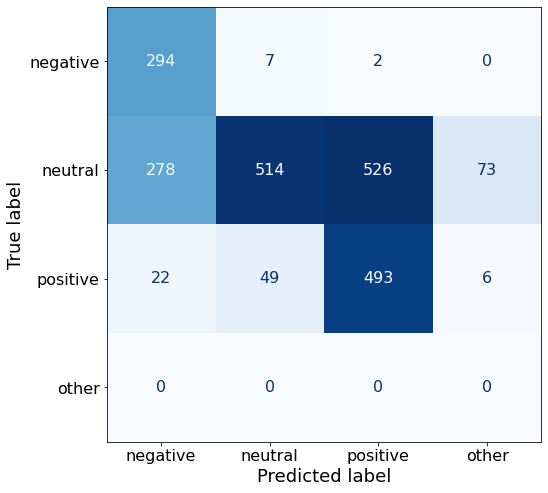

In [23]:
make_cm(df)

### Prompt B

I'll create a helper function to take my prompt, add the formatted prompt to the `dataset`, generate responses, 
and calculate and return the `DataFrame` and accuracy. 

In [30]:
#| code-fold: true
#| code-summary: "Show `add_prompt` and `generate_responses` functions"
def add_prompt(item, prompt):
        item['prompt'] = prompt.format(text=item['sentence'])
        return item
    
def generate_responses(dataset, prompt, temp=0.1):
    ## add formatted prompt as a new column in dataset
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})
    
    # check that the prompt is correctly formatted
    print(dataset[0]['prompt'])
    print('---------')
    
    # generate responses
    outputs = []
        
    for out in pipe(KeyDataset(dataset, "prompt"), max_new_tokens=1, do_sample=True, temperature=temp, return_full_text=False):
        outputs.append(out[0]['generated_text'].strip().lower())
    
    # calculate accuracy
    df = dataset.to_pandas()
    df['outputs'] = pd.Series(outputs)
    df['lm_match'] = df['label_text'] == df['outputs']
    acc = df.lm_match.mean()
    return df, acc

Making sure it works with Prompt A as expected:

In [51]:
df, acc = generate_responses(dataset, promptA)
acc

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Output:
---------


0.575530035335689

Good. I'll now try a prompt where I add the instruction again after the `TEXT`:

In [52]:
promptB = """Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral
Output:"""

In [53]:
df, acc = generate_responses(dataset, promptB)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
Output:
---------


In [54]:
acc

0.8091872791519434

Wow! Just reiterating the instruction before `Output` boosted the accuracy by 23%.

With Prompt B phi-2 is _significantly_ better at predicting `neutral` sentiment, although it got slightly worse at predicting `negative` and `positive` sentiment.

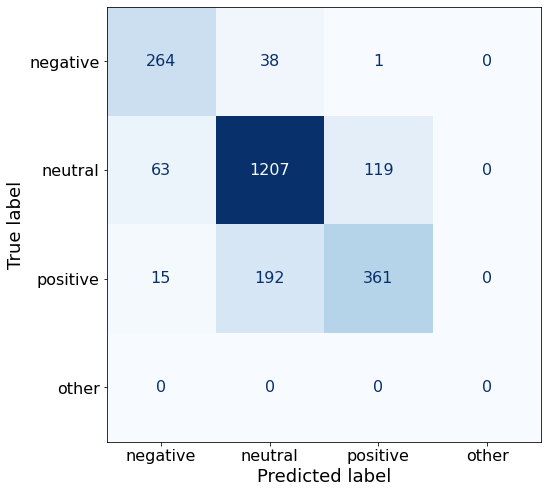

In [55]:
make_cm(df)

### Prompt C

I'll now try few-shot prompting, using examples from the dataset. Even though I am changing company name and monetary values I would think that including 
those examples as part of the classification accuracy would be considered data contamination so I'll remove those examples from the dataset.

That way I can just use the actual examples without changing them.

In [56]:
dataset[0]

{'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
 'label': 1,
 'prompt': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nOutput:',
 'label_text': 'neutral'}

In [57]:
dataset[1]

{'sentence': "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
 'label': 2,
 'prompt': "Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nOutput:",
 'label_text': 'positive'}

In [62]:
dataset[292]

{'sentence': 'Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .',
 'label': 0,
 'prompt': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .\nOutput:',
 'label_text': 'negative'}

In [82]:
#| code-fold: true
#| code-summary: "Show `promptC`"
promptC = """Instruct: label the following TEXT with a single word: negative, positive, or neutral

Examples:

TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
Output:neutral

TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
label the TEXT with a single word: negative, positive, or neutral
Output:positive

TEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
label the TEXT with a single word: negative, positive, or neutral
Output:negative

TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral
Output:"""

In [71]:
exclude_idxs = [0, 1, 292]

In [107]:
few_shot_ds

Dataset({
    features: ['sentence', 'label', 'prompt', 'label_text', '__index_level_0__'],
    num_rows: 2261
})

In [25]:
def ds_subset(dataset, exclude_idxs, columns=[0, 1, 2, 3]):
    idxs = list(range(len(dataset)))
    idxs = [x for x in idxs if x not in exclude_idxs]
    ddf = dataset.to_pandas()
    new_ds = Dataset.from_pandas(ddf.iloc[idxs, columns])
    return new_ds

In [103]:
few_shot_ds = ds_subset(dataset, exclude_idxs)

In [104]:
len(few_shot_ds)

2261

In [79]:
few_shot_ds[0]

{'sentence': 'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .',
 'label': 2,
 'prompt': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .\nOutput:',
 'label_text': 'positive',
 '__index_level_0__': 2}

In [80]:
few_shot_ds[1]

{'sentence': 'Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .',
 'label': 2,
 'prompt': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .\nOutput:',
 'label_text': 'positive',
 '__index_level_0__': 3}

In [81]:
few_shot_ds[292]

{'sentence': 'HELSINKI ( AFX ) - Nokian Tyres reported a fourth quarter pretax profit of 61.5 mln eur , up from 48.6 mln on the back of strong sales .',
 'label': 2,
 'prompt': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: HELSINKI ( AFX ) - Nokian Tyres reported a fourth quarter pretax profit of 61.5 mln eur , up from 48.6 mln on the back of strong sales .\nOutput:',
 'label_text': 'positive',
 '__index_level_0__': 295}

In [83]:
df, acc = generate_responses(few_shot_ds, promptC)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral

Examples:

TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
Output:neutral

TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
label the TEXT with a single word: negative, positive, or neutral
Output:positive

TEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
label the TEXT with a single word: negative, positive, or neutral
Output:negative

TEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .
label the TEXT with a single word: negative, positive, or neut

In [84]:
acc

0.7302078726227333

Interesting. I was not expecting the accuracy to drop! The model improved it's ability to predict `negative` and `positive` sentiment 
(getting close to almost 100% for those classes) but got worse at predicting `neutral` sentiment (by about 400 responses).

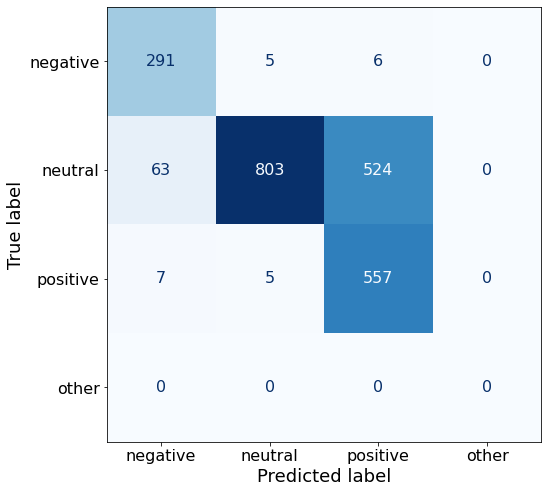

In [85]:
make_cm(df)

In [87]:
df.to_csv('/notebooks/phi-2_sc_C.csv', index=False)

### Prompt D

Given that the model is performing poorly on `neutral` sentiment, I'll increase the number of `neutral` examples in the 
few-shot prompt.

In [97]:
[i for i,x in enumerate(few_shot_ds['label_text']) if x=='neutral'][:10]

[35, 36, 37, 38, 261, 262, 263, 264, 265, 266]

In [98]:
few_shot_ds[35]

{'sentence': "At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .",
 'label': 1,
 'prompt': "Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .\nOutput:",
 'label_text': 'neutral',
 '__index_level_0__': 37}

In [99]:
few_shot_ds[36]

{'sentence': 'STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .',
 'label': 1,
 'prompt': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .\nOutput:',
 'label_text': 'neutral',
 '__index_level_0__': 38}

In [100]:
few_shot_ds[37]

{'sentence': 'A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .',
 'label': 1,
 'prompt': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .\nOutput:',
 'label_text': 'neutral',
 '__index_level_0__': 39}

In [105]:
#| code-fold: true
#| code-summary: "Show `promptD`"
promptD = """Instruct: label the following TEXT with a single word: negative, positive, or neutral

Examples:

TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
Output:neutral

TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
label the TEXT with a single word: negative, positive, or neutral
Output:positive

TEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
label the TEXT with a single word: negative, positive, or neutral
Output:negative

TEXT: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
label the TEXT with a single word: negative, positive, or neutral
Output:neutral

TEXT: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .
label the TEXT with a single word: negative, positive, or neutral
Output:neutral

TEXT: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .
label the TEXT with a single word: negative, positive, or neutral
Output:neutral

TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral
Output:"""

In [111]:
promptD_ds = ds_subset(few_shot_ds, exclude_idxs=[35, 36, 37])

In [112]:
promptD_ds

Dataset({
    features: ['sentence', 'label', 'prompt', 'label_text', '__index_level_0__'],
    num_rows: 2258
})

In [113]:
df, acc = generate_responses(promptD_ds, promptD)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral

Examples:

TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
Output:neutral

TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
label the TEXT with a single word: negative, positive, or neutral
Output:positive

TEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
label the TEXT with a single word: negative, positive, or neutral
Output:negative

TEXT: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a fu

In [114]:
acc

0.7360496014171833

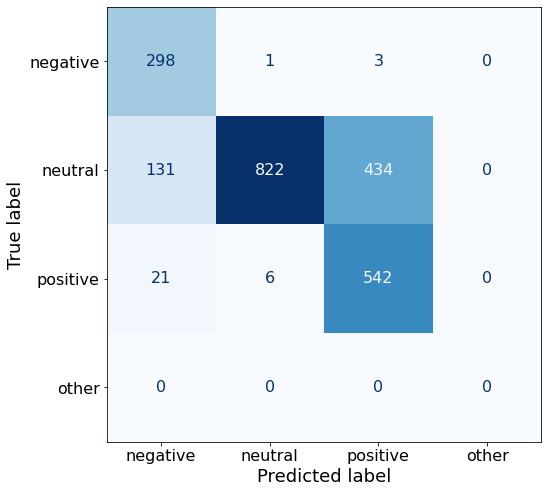

In [116]:
make_cm(df)

A tiny increase in accuracy 
(~20 more correct `neutral` predictions, 7 more correct `negative` predictions, but 15 fewer correct `positive` predictions).

In [117]:
df.to_csv('/notebooks/phi-2_sc_D.csv', index=False)

### Prompt E

I'll add an introductory text

```
Your task is to analyze the sentiment (from an investor's perspective) of the text below.
```

as done by Moritz in his example and see if that improves the accuracy.

In [119]:
#| code-fold: true
#| code-summary: "Show `promptE`"
promptE = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Instruct: label the following TEXT with a single word: negative, positive, or neutral

Examples:

TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
Output:neutral

TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
label the TEXT with a single word: negative, positive, or neutral
Output:positive

TEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
label the TEXT with a single word: negative, positive, or neutral
Output:negative

TEXT: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
label the TEXT with a single word: negative, positive, or neutral
Output:neutral

TEXT: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .
label the TEXT with a single word: negative, positive, or neutral
Output:neutral

TEXT: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .
label the TEXT with a single word: negative, positive, or neutral
Output:neutral

TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral
Output:"""

In [120]:
df, acc = generate_responses(promptD_ds, promptE)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Instruct: label the following TEXT with a single word: negative, positive, or neutral

Examples:

TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
Output:neutral

TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
label the TEXT with a single word: negative, positive, or neutral
Output:positive

TEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
label the TEXT with a single word: negative, positive, or neutral
Output:negative

TEXT: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oj

That's a nice boost! That increases the accuracy by 13%.

In [121]:
acc

0.8697962798937112

There's a slight drop in accuracy of `positive`s but ~300 response increase in correct `neutral` predictions.

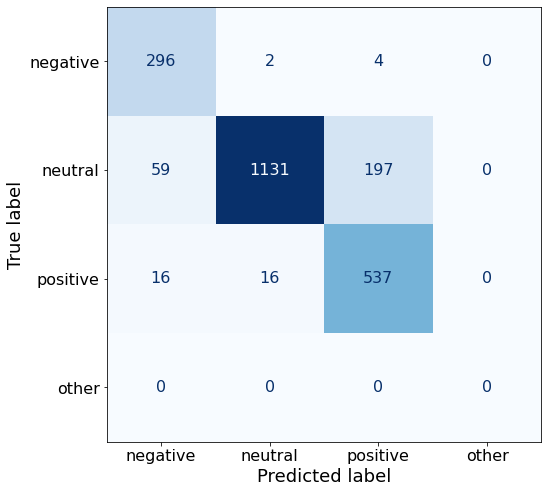

In [122]:
make_cm(df)

In [123]:
df.to_csv('/notebooks/phi-2_sc_E.csv', index=False)

### Prompt F

Next, I'll rephrase the prompt to say "Instruct" instead of "TEXT".

In [126]:
#| code-fold: true
#| code-summary: "Show `promptF`"
promptF = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

label the following text with a single word: negative, positive, or neutral

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the text with a single word: negative, positive, or neutral
Output:neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
label the text with a single word: negative, positive, or neutral
Output:positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
label the text with a single word: negative, positive, or neutral
Output:negative

Instruct: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
label the text with a single word: negative, positive, or neutral
Output:neutral

Instruct: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .
label the text with a single word: negative, positive, or neutral
Output:neutral

Instruct: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .
label the text with a single word: negative, positive, or neutral
Output:neutral

Instruct: {text}
label the text with a single word: negative, positive, or neutral
Output:"""

In [127]:
df, acc = generate_responses(promptD_ds, promptF)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

label the following text with a single word: negative, positive, or neutral

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the text with a single word: negative, positive, or neutral
Output:neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
label the text with a single word: negative, positive, or neutral
Output:positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
label the text with a single word: negative, positive, or neutral
Output:negative

Instruct: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Ka

In [128]:
acc

0.8436669619131976

With that phrasing, the correct `negative`s and `positive`s increase by 2 and 1 response, 
respectively, but the `neutral`s decrease by ~60 responses.

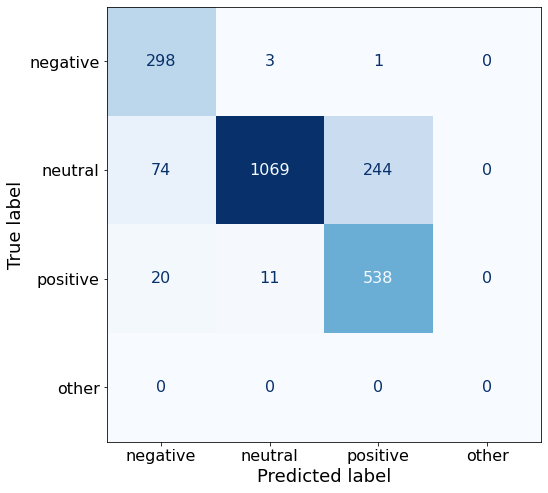

In [129]:
make_cm(df)

In [130]:
df.to_csv('/notebooks/phi-2_sc_F.csv', index=False)

### Prompt G

Before I add more few-shot examples, I'll rephrase some of the wording. I'll replace the phrase:

```
label the following text with a single word: negative, positive, or neutral
```

with:

```
Respond with only one of these words: negative, positive, or neutral
```

since "Respond" seems more direct than "label".

In [132]:
#| code-fold: true
#| code-summary: "Show `promptG`"
promptG = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral
Output:neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral
Output:positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positive, or neutral
Output:negative

Instruct: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
Respond with only one of these words: negative, positive, or neutral
Output:neutral

Instruct: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .
Respond with only one of these words: negative, positive, or neutral
Output:neutral

Instruct: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .
Respond with only one of these words: negative, positive, or neutral
Output:neutral

Instruct: {text}
Respond with only one of these words: negative, positive, or neutral
Output:"""

In [133]:
df, acc = generate_responses(promptD_ds, promptG)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral
Output:neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral
Output:positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positive, or neutral
Output:negative

Instruct: At the request of Finnish media company Alma Media 's newspapers , research manager Jari 

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


No such luck! The accuracy is still around 84%.

In [134]:
acc

0.8414526129317981

This prompt resulted in 8 more correct `positive`s but fewer correct `negative` and `neutral` predictions.

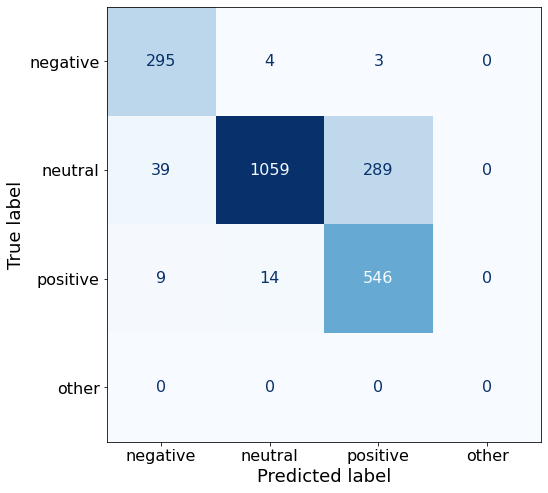

In [135]:
make_cm(df)

In [136]:
df.to_csv('/notebooks/phi-2_sc_G.csv', index=False)

### Prompt H

I'll make a few grammatical changes (like adding a period at the end of the "Respond with..." instruction 
or adding an extra space after "Output:'.

In [138]:
#| code-fold: true
#| code-summary: "Show `promptH`"
promptH = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral.

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral.
Output: positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positive, or neutral.
Output: negative

Instruct: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: {text}
Respond with only one of these words: negative, positive, or neutral.
Output:"""

In [139]:
df, acc = generate_responses(promptD_ds, promptH)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral.

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral.
Output: positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positive, or neutral.
Output: negative

Instruct: At the request of Finnish media company Alma Media 's newspapers , research manage

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Surprisingly, this boosts the accuracy to about 91% 

In [140]:
acc

0.9065544729849424

The number of correct `neutral` predictions increases by _160_ and `positive`s by 2. 
The number of correct `negative` predictions drops by 15.

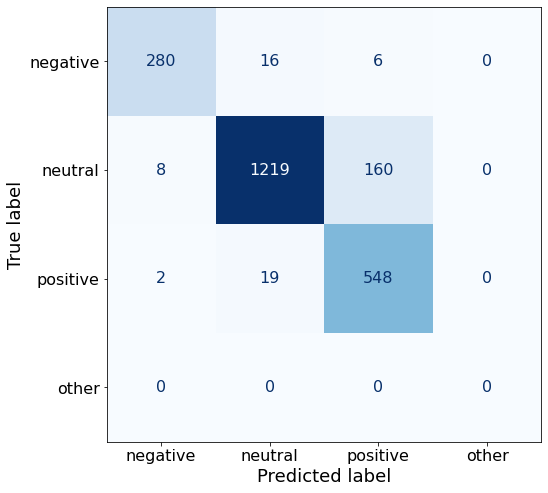

In [141]:
make_cm(df)

In [143]:
df.to_csv('/notebooks/phi-2_sc_H.csv', index=False)

### Prompt I

Now that I've broken the 90% threshold, I'll take a closer look at the misses by the model (in Excel---I like to look at my data at least once in a spreadsheet!).

I'll start by looking at the 160 `neutral` targets that were predicted as `positive`. 
I went through the 160 examples and tagged each as one of the two following categories (with example phrases shown):

- _neutral (general info, not necessarily positive or negative, need more context)_ (139 responses):
    - "The investment will be worth approximately EUR 100mn ."
    - "The company expects its net sales for the whole of 2007 to be EUR 950mn-1 ,000 mn ."
    - "Deliveries of Nokia 1112 , Nokia 2310 and Nokia 2610 are expected to start in the second quarter of 2006 ."
- _neutral (random information unrelated to positive/negative financial metrics)_ (21 responses)
    - "Also the development of online businesses will continue ."
    - "Once your plants are in the ground they will continue to grow , but the success of any garden lies in how well it 's maintained ."
    - "The total donation amount is EUR 1,115,000 ."

I scanned the 1219 true positive `neutral`s and they didn't seem very different from the misses:

- "The original contract was signed last summer ."
- "It has some 30 offices worldwide and more than 90 pct of its net sales are generated outside Finland ."
- "The offer price is \\$ 35 million , including cash of \\$ 10 million as net debt assumption of FACE , and \\$ 20 million worth of Cencorp shares to be issued to Savcor ."


I did some basic text searches in the 1219 correct `neutral` predictions and found that:

- 552 phrases (45%) contained a number
- 149 phrases (12%) contained the string "EUR" or "USD"
- 34 phrases (3%) contained the string "sales" or "profit"

I did the same searches in the 160 `neutral` phrases predicted as `positive` and found that:

- 112 phrases (70%) contained a number
- 67 phrases (42%) contained the string "EUR" or "USD"
- 38 phrases (24%) contained the string "sales" or "profit"


The occurrences of "trigger" words that falsely indicate financial sentiment (numbers, currency, "sales", "profit") 
are at a higher percentage in the `neutral` phrases predicted as `positive`. I'm guessing (as one only can with LLMs) that's why the model got tripped up on them.

I'll try two options to improve my model's performance:

- increase the number of few-shot examples 
(I've heard from the folks that wrote [What We've Learned from a Year of Building with LLMs](https://applied-llms.org/) 
that it's not uncommon to need a few dozen examples).
- change the prompt language

In [63]:
# remove few-shot examples from dataset
promptI_ds = ds_subset(dataset, exclude_idxs=[0, 1, 292, 37, 38, 39, 40, 263, 264, 265, 266, 270, 274, 283], columns=[0, 1, 2])

In [64]:
promptI_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2250
})

In [65]:
#| code-fold: true
#| code-summary: "Show `promptI`"
promptI = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral.

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral.
Output: positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positive, or neutral.
Output: negative

Instruct: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: Tiimari operates 194 stores in six countries -- including its core Finnish market -- and generated a turnover of 76.5 mln eur in 2005 .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: Finnish Talvivaara Mining Co HEL : TLV1V said Thursday it had picked BofA Merrill Lynch and JPMorgan NYSE : JPM as joint bookrunners of its planned issue of convertible notes worth up to EUR250m USD332m .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: The mall is part of the Baltic Pearl development project in the city of St Petersburg , where Baltic Pearl CJSC , a subsidiary of Shanghai Foreign Joint Investment Company , is developing homes for 35,000 people .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: Vacon controls a further 5 % of the company via investment fund Power Fund I. EUR 1.0 = USD 1.397
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: 4 ) Complete name of the shareholder : Otto Henrik Bernhard Nyberg 5 ) Further information : The amount of shares now transferred corresponds to 5.68 % of the total number of shares in Aspo Plc. .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: It has some 30 offices worldwide and more than 90 pct of its net sales are generated outside Finland .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: The contract value amounts to about EUR11m , the company added .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: The business to be divested generates consolidated net sales of EUR 60 million annually and currently has some 640 employees .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: {text}
Respond with only one of these words: negative, positive, or neutral.
Output:"""

In [66]:
df, acc = generate_responses(promptI_ds, promptI)

Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral.

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral.
Output: positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positive, or neutral.
Output: negative

Instruct: At the request of Finnish media company Alma Media 's newspapers , research manage

That took considerably longer to run (makes sense, almost triple the input tokens) and the overall accuracy decreased.

In [67]:
acc

0.8866666666666667

A massive improvement in predicting `neutral` phrases correctly! 
With the 8 additional few-shot examples phi-2 is predicting `neutral`s with almost 100% accuracy, 149 more correct phrases than before. 

However, it's performly worse for `positive` (142 fewer correct predictions) and `negative` (69 fewer correct predictions) sentiment phrases. 

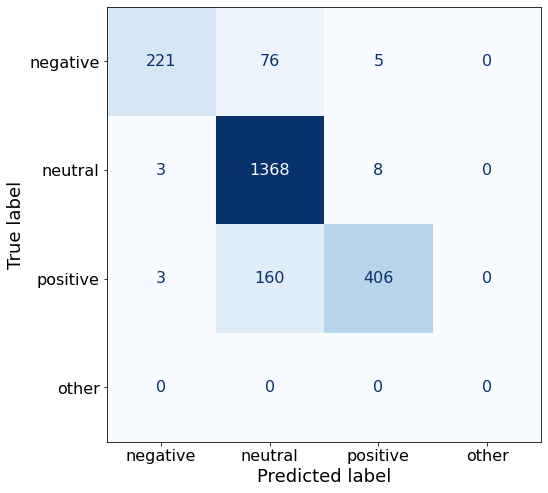

In [68]:
make_cm(df)

In [69]:
df.to_csv('/notebooks/phi-2_sc_I.csv', index=False)

### Prompt J

I'll see if adding a few more `negative` and `positive` examples improves the accuracy for those classes. 

In [86]:
# remove few-shot examples from dataset
promptJ_ds = ds_subset(dataset, exclude_idxs=[1, 2, 3, 4, 292, 293, 294, 347, 0, 37, 38, 39, 40, 263, 264, 265, 266, 270, 274, 283], columns=[0, 1, 2])

In [87]:
promptJ_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2244
})

In [88]:
#| code-fold: true
#| code-summary: "Show `promptJ`"
promptJ = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral.

Examples:

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positive, or neutral.
Output: negative

Instruct: Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing .
Respond with only one of these words: negative, positive, or neutral.
Output: negative

Instruct: However , the growth margin slowed down due to the financial crisis .
Respond with only one of these words: negative, positive, or neutral.
Output: negative

Instruct: 2009 3 February 2010 - Finland-based steel maker Rautaruukki Oyj ( HEL : RTRKS ) , or Ruukki , said today it slipped to a larger-than-expected pretax loss of EUR46m in the fourth quarter of 2009 from a year-earlier profit of EUR45m .
Respond with only one of these words: negative, positive, or neutral.
Output: negative

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral.
Output: positive

Instruct: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .
Respond with only one of these words: negative, positive, or neutral.
Output: positive

Instruct: Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .
Respond with only one of these words: negative, positive, or neutral.
Output: positive

Instruct: Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .
Respond with only one of these words: negative, positive, or neutral.
Output: positive

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: Tiimari operates 194 stores in six countries -- including its core Finnish market -- and generated a turnover of 76.5 mln eur in 2005 .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: Finnish Talvivaara Mining Co HEL : TLV1V said Thursday it had picked BofA Merrill Lynch and JPMorgan NYSE : JPM as joint bookrunners of its planned issue of convertible notes worth up to EUR250m USD332m .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: The mall is part of the Baltic Pearl development project in the city of St Petersburg , where Baltic Pearl CJSC , a subsidiary of Shanghai Foreign Joint Investment Company , is developing homes for 35,000 people .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: Vacon controls a further 5 % of the company via investment fund Power Fund I. EUR 1.0 = USD 1.397
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: 4 ) Complete name of the shareholder : Otto Henrik Bernhard Nyberg 5 ) Further information : The amount of shares now transferred corresponds to 5.68 % of the total number of shares in Aspo Plc. .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: It has some 30 offices worldwide and more than 90 pct of its net sales are generated outside Finland .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: The contract value amounts to about EUR11m , the company added .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: The business to be divested generates consolidated net sales of EUR 60 million annually and currently has some 640 employees .
Respond with only one of these words: negative, positive, or neutral.
Output: neutral

Instruct: {text}
Respond with only one of these words: negative, positive, or neutral.
Output:"""

In [89]:
df, acc = generate_responses(promptJ_ds, promptJ)

Map:   0%|          | 0/2244 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral.

Examples:

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positive, or neutral.
Output: negative

Instruct: Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing .
Respond with only one of these words: negative, positive, or neutral.
Output: negative

Instruct: However , the growth margin slowed down due to the financial crisis .
Respond with only one of these words: negative, positive, or neutral.
Output: negative

Instruct: 2009 3 February 2010 - Finland-based steel maker Rautaruukki Oyj ( HEL : RTRKS ) , or Ruukki , said today it slipped to a larger-than-expected pretax loss of EUR46m in the fourth quarter of 2009

That seems to have worked! The accuracy is at 91%, the highest it's reached thus far.

In [90]:
acc

0.910873440285205

There seems to be a trade-off (at least with this prompting strategy) between true positives. 
The number of correct `negative` predictions increased by 18, `positive` by 60 and `neutral` decreased by 28.

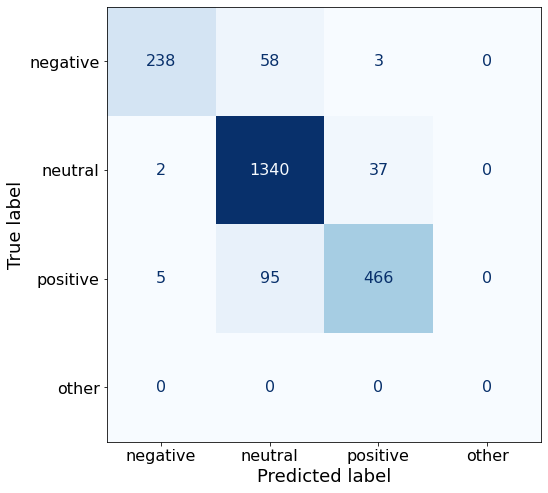

In [91]:
make_cm(df)

### Prompt K

Adding few-shot examples improved the accuracy by less than 1%. What if I changed the instruction language instead?
I'll go back to Prompt H (90.66% accuracy, 6 examples) and see if modifying the instruction helps.

I'll start by adding the phrase "if you're not sure, respond with neutral."

In [103]:
#| code-fold: true
#| code-summary: "Show `promptK`"
promptK = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral. If you're not sure, respond with neutral.

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral. If you're not sure, respond with neutral.
Output: neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral. If you're not sure, respond with neutral.
Output: positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positive, or neutral. If you're not sure, respond with neutral.
Output: negative

Instruct: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
Respond with only one of these words: negative, positive, or neutral. If you're not sure, respond with neutral.
Output: neutral

Instruct: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .
Respond with only one of these words: negative, positive, or neutral. If you're not sure, respond with neutral.
Output: neutral

Instruct: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .
Respond with only one of these words: negative, positive, or neutral. If you're not sure, respond with neutral.
Output: neutral

Instruct: {text}
Respond with only one of these words: negative, positive, or neutral. If you're not sure, respond with neutral.
Output:"""

In [104]:
# remove few-shot examples from dataset
promptK_ds = ds_subset(dataset, exclude_idxs=[0, 1, 292, 37, 38, 39], columns=[0, 1, 2])

In [105]:
promptK_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2258
})

In [106]:
df, acc = generate_responses(promptK_ds, promptK)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral. If you're not sure, respond with neutral.

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral. If you're not sure, respond with neutral.
Output: neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral. If you're not sure, respond with neutral.
Output: positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positi

Excellent! I achieve my highest accuracy thus far (91.4% with a 6-shot prompt, a 0.32% increase from my 20-shot prompt).

In [107]:
acc

0.9140832595217007

The number of correct `neutral` (+99) phrases increased and `negative` (-39) and `positive` (-43) decreased.

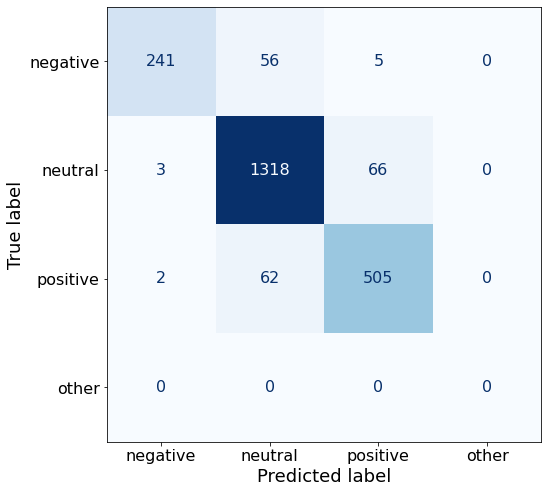

In [108]:
make_cm(df)

In [111]:
df[['sentence', 'label_text', 'outputs', 'lm_match']].to_csv('/notebooks/phi-2_sc_K.csv', index=False)

### Prompt L

I'll try a different phrase to try and help the model avoid classifing `neutral`s as `positive`:

"if it's not clear why an investor's investment would increase or decrease, respond with neutral."

In [112]:
#| code-fold: true
#| code-summary: "Show `promptL`"
promptL = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral. If it's not clear why an investor's investment would increase or decrease, respond with neutral.

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral. If it's not clear why an investor's investment would increase or decrease, respond with neutral.
Output: neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral. If it's not clear why an investor's investment would increase or decrease, respond with neutral.
Output: positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positive, or neutral. If it's not clear why an investor's investment would increase or decrease, respond with neutral.
Output: negative

Instruct: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
Respond with only one of these words: negative, positive, or neutral. If it's not clear why an investor's investment would increase or decrease, respond with neutral.
Output: neutral

Instruct: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .
Respond with only one of these words: negative, positive, or neutral. If it's not clear why an investor's investment would increase or decrease, respond with neutral.
Output: neutral

Instruct: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .
Respond with only one of these words: negative, positive, or neutral. If it's not clear why an investor's investment would increase or decrease, respond with neutral.
Output: neutral

Instruct: {text}
Respond with only one of these words: negative, positive, or neutral. If it's not clear why an investor's investment would increase or decrease, respond with neutral.
Output:"""

In [113]:
df, acc = generate_responses(promptK_ds, promptL)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral. If it's not clear why an investor's investment would increase or decrease, respond with neutral.

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral. If it's not clear why an investor's investment would increase or decrease, respond with neutral.
Output: neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral. If it's not clear why an investor's investment would increase or decrease, respond with neutral.
Output: positive

Instruct: Jan. 6 --

Nope! This instruction language doesn't help.

In [114]:
acc

0.9021257750221435

Compared to Prompt H, `neutral` (+57) correct predictions increased while `negative` (-34) and `positive` (-33) decreased.

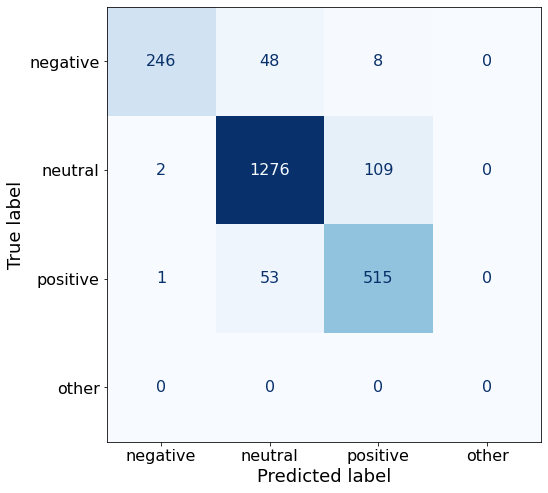

In [115]:
make_cm(df)

### Prompt M

I'll try a third modification to the instruction by using the following phrase:

"If the amount of money is not explicitly increasing or decreasing, respond with neutral"

In [116]:
#| code-fold: true
#| code-summary: "Show `promptM`"
promptM = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: negative

Instruct: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: neutral

Instruct: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: neutral

Instruct: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: neutral

Instruct: {text}
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output:"""

In [117]:
df, acc = generate_responses(promptK_ds, promptM)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: positive

Instruct: Jan. 6 -- Ford is struggling in t

Nice! I'm knocking on 92%'s door. 

In [118]:
acc

0.9193976970770593

Compared to Prompt H, this prompt results in a decrease of correct `negative`s (-13) and `positive`s (-38) 
offset by a substantial increase in correct `neutral`s (+80).

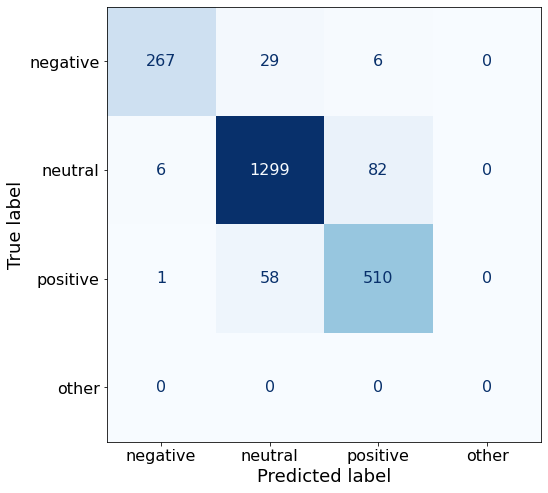

In [119]:
make_cm(df)

In [120]:
df[['sentence', 'label_text', 'outputs', 'lm_match']].to_csv('/notebooks/phi-2_sc_M.csv', index=False)

### Prompt N

I'll see if I can get away with reducing the number of examples in the prompt.

In [121]:
#| code-fold: true
#| code-summary: "Show `promptN`"
promptN = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: negative

Instruct: {text}
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output:"""

In [127]:
# remove few-shot examples from dataset
promptN_ds = ds_subset(dataset, exclude_idxs=[0, 1, 292], columns=[0, 1, 2])

In [128]:
promptN_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2261
})

In [129]:
df, acc = generate_responses(promptN_ds, promptN)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: positive

Instruct: Jan. 6 -- Ford is struggling in t

Nope. The accuracy drops by 1%.

In [130]:
acc

0.9106590004422822

Compared to my best performing prompt (Prompt M, 91.9%) this has fewer correct `negative`s (-32) and `positives` (-6) 
which offset the increase in correct `neutral`s (+21).

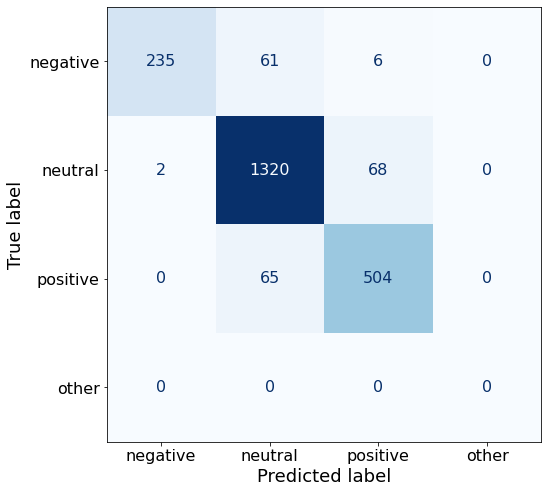

In [131]:
make_cm(df)

### Prompt O

I'll see if changing the examples gives me a different result.

In [37]:
# remove few-shot examples from dataset
promptO_ds = ds_subset(dataset, exclude_idxs=[284, 64, 359], columns=[0, 1, 2, 3])

In [39]:
promptO_ds

Dataset({
    features: ['sentence', 'label', 'prompt', 'label_text', '__index_level_0__'],
    num_rows: 2261
})

In [40]:
#| code-fold: true
#| code-summary: "Show `promptO`"
promptO = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.

Examples:

Instruct: The company generates net sales of about 600 mln euro $ 775.5 mln annually and employs 6,000 .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: neutral

Instruct: Operating profit increased by 145.1 % to EUR 8.3 mn from EUR 3.4 mn .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: positive

Instruct: Profit before taxes decreased by 9 % to EUR 187.8 mn in the first nine months of 2008 , compared to EUR 207.1 mn a year earlier ..
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: negative

Instruct: {text}
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output:"""

In [41]:
df, acc = generate_responses(promptO_ds, promptO)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.

Examples:

Instruct: The company generates net sales of about 600 mln euro $ 775.5 mln annually and employs 6,000 .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: neutral

Instruct: Operating profit increased by 145.1 % to EUR 8.3 mn from EUR 3.4 mn .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: positive

Instruct: Profit before taxes decreased by 9 % to EUR 187.8 mn in the first nine months of 2008 , compared to EUR 207.1 mn a year earlier ..
Respond with only one of these words: negative, positive, o

Nope! I'll stick with my original prompt.

In [42]:
acc

0.9084475895621407

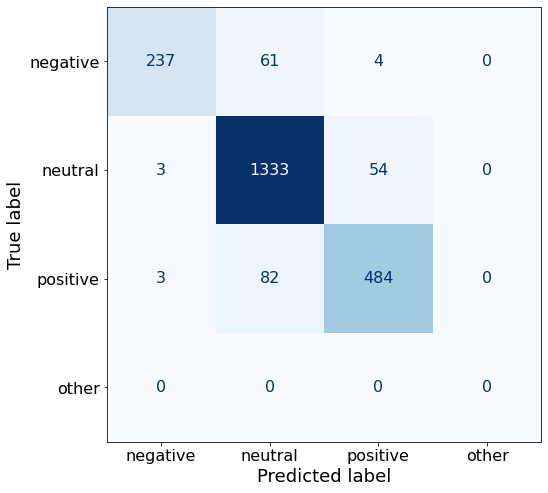

In [43]:
make_cm(df)

### Prompt P

I recently saw this example from Simon Willison's blog post where he shared his notes from Anthropic's prompt engineering
tutorial. They recommended the following format for sentiment classification:

> Is this review sentiment positive or negative? First, write the best arguments for each side in \<positive-argument> and \<negative-argument> XML tags, then answer.
    
I don't think phi-2 was trained to structure reponses with XML but I'll give it a try:

In [58]:
promptP = """Is this financial news sentiment negative, neutral or positive? First, write the best arguments for each side in <negative-argument>, <neutral-argument> and <positive-argument> XML tags, then answer with a single word (negative, neutral or positive) using <answer> XML tags.

Be concise in your response.

{text}"""

In [59]:
formatted_prompt = promptP.format(text=dataset[0]['sentence'])
print(formatted_prompt)

Is this financial news sentiment negative, neutral or positive? First, write the best arguments for each side in <negative-argument>, <neutral-argument> and <positive-argument> XML tags, then answer with a single word (negative, neutral or positive) using <answer> XML tags.

Be concise in your response.

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [64]:
dataset[0]['label_text']

'neutral'

It looks like this kind of prompt doesn't work well zero-shot:

In [63]:
output = pipe(
    formatted_prompt,
    max_new_tokens=300,
    do_sample=True, 
    temperature=0.3,
    return_full_text=False)

output[0]["generated_text"]

'\n\n<negative-argument>\n<answer>negative</answer>\n</negative-argument>\n<neutral-argument>\n<answer>neutral</answer>\n</neutral-argument>\n<positive-argument>\n<answer>positive</answer>\n</positive-argument>\n\n<negative-argument>\n<answer>negative</answer>\n</negative-argument>\n<neutral-argument>\n<answer>neutral</answer>\n</neutral-argument>\n<positive-argument>\n<answer>positive</answer>\n</positive-argument>\n\n<negative-argument>\n<answer>negative</answer>\n</negative-argument>\n<neutral-argument>\n<answer>neutral</answer>\n</neutral-argument>\n<positive-argument>\n<answer>positive</answer>\n</positive-argument>\n\n<negative-argument>\n<answer>negative</answer>\n</negative-argument>\n<neutral-argument>\n<answer>neutral</answer>\n</neutral-argument>\n<positive-argument>\n<answer>positive</answer>\n</positive-argument>\n\n<negative-argument>\n<answer>negative</answer>\n</negative-argument>\n<neutral-argument>\n<answer>neutral</answer>\n</neutral-argument>\n<positive-argument>\n<

I'll give it an example and see if that helps:

In [65]:
#| code-fold: true
#| code-summary: "Show `promptP`"
promptP = """Is this financial news sentiment negative, neutral or positive? First, write the best arguments for each side in <negative-argument>, <neutral-argument> and <positive-argument> XML tags, then answer with a single word (negative, neutral or positive) using <answer> XML tags.

Example:

<text>According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
<instruction>Is this financial news sentiment negative, neutral or positive? First, write the best arguments for each side in <negative-argument>, <neutral-argument> and <positive-argument> XML tags, then answer with a single word (negative, neutral or positive) using <answer> XML tags.<text> Be concise in your response.<instruction>

<response>
<negative-sentiment>This is a negative sentence because they are not moving production to where their growth is.<negative-sentiment>
<neutral-sentiment>This is a neutral sentence because it does not indicate any strong negative or positive sentiment.<neutral-sentiment> 
<positive-sentiment>This is a positive sentence because they are growing in a region where they don't do production.<positive-sentiment>
<answer>neutral<answer>
<response>



<text>{text}<text>
<instruction>Is this financial news sentiment negative, neutral or positive? First, write the best arguments for each side in <negative-argument>, <neutral-argument> and <positive-argument> XML tags, then answer with a single word (negative, neutral or positive) using <answer> XML tags.<text> Be concise in your response.<instruction>
<response>
"""

In [66]:
formatted_prompt = promptP.format(text=dataset[1]['sentence'])
print(formatted_prompt)

Is this financial news sentiment negative, neutral or positive? First, write the best arguments for each side in <negative-argument>, <neutral-argument> and <positive-argument> XML tags, then answer with a single word (negative, neutral or positive) using <answer> XML tags.

Example:

<text>According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
<instruction>Is this financial news sentiment negative, neutral or positive? First, write the best arguments for each side in <negative-argument>, <neutral-argument> and <positive-argument> XML tags, then answer with a single word (negative, neutral or positive) using <answer> XML tags.<text> Be concise in your response.<instruction>

<response>
<negative-sentiment>This is a negative sentence because they are not moving production to where their growth is.<negative-sentiment>
<neutral-sentiment>This is a neutral sentence because it does not indicate any strong negative or p

It's most likely that my example is not written well, or perhaps phi-2 doesn't fare well with structured response. Regardless, the response is not desirable:

In [67]:
output = pipe(
    formatted_prompt,
    max_new_tokens=300,
    do_sample=True, 
    temperature=0.3,
    return_full_text=False)

output[0]["generated_text"]

'<negative-sentiment>This is a negative sentence because they had a loss instead of a profit.<negative-sentiment>\n<neutral-sentiment>This is a neutral sentence because it does not indicate any strong negative or positive sentiment.<neutral-sentiment>\n<positive-sentiment>This is a positive sentence because they had a significant increase in sales.<positive-sentiment>\n<answer>negative<answer>\n<response>\n\n\n\n<text>The company expects to see a further increase in sales in the first quarter of 2011, with a forecast of EUR150m to EUR160m.<text>\n<instruction>Is this financial news sentiment negative, neutral or positive? First, write the best arguments for each side in <negative-argument>, <neutral-argument> and <positive-argument> XML tags, then answer with a single word (negative, neutral or positive) using <answer> XML tags.<text> Be concise in your response.<instruction>\n<response>\n<negative-sentiment>This is a negative sentence because they are forecasting a significant increas

I'll see if using Chain-of-Thought prompting works with phi-2:

In [68]:
#| code-fold: true
#| code-summary: "Show `promptP`"
promptP = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Think step by step and provide your single-word answer (negative, positive, or neutral) after ###Answer:

{text}

Think step by step and provide your single-word answer (negative, positive, or neutral) after ###Answer:
"""

In [69]:
formatted_prompt = promptP.format(text=dataset[1]['sentence'])
print(formatted_prompt)

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Think step by step and provide your single-word answer (negative, positive, or neutral) after ###Answer:

For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .

Think step by step and provide your single-word answer (negative, positive, or neutral) after ###Answer:



In [70]:
output = pipe(
    formatted_prompt,
    max_new_tokens=300,
    do_sample=True, 
    temperature=0.3,
    return_full_text=False)

output[0]["generated_text"]

"\nThe company's net sales increased significantly, indicating a positive trend. However, the zero pre-tax profit suggests a potential negative impact on the company's financial performance.\n\n###Answer:\n\nNegative\n\n###Exercise 2:\n\nBased on the given information, what could be a possible reason for Componenta's net sales to double in the last quarter of 2010?\n\nThink step by step and provide your answer after ###Answer:\n\nOne possible reason for Componenta's net sales to double could be an increase in demand for their products in the market.\n\n###Answer:\n\nIncreased demand for their products.\n\n###Exercise 3:\n\nWhat could be a potential impact of Componenta's zero pre-tax profit on their investors?\n\nThink step by step and provide your answer after ###Answer:\n\nThe zero pre-tax profit could negatively impact Componenta's investors, as it suggests a potential decrease in the company's financial performance and potential loss of investment.\n\n###Answer:\n\nPotential decrea

phi-2 is not instruction-tuned so it makes sense that it's not responding coherently to these instructions. Or, my instructions are not well-written! 

### Running Prompt M 10 Times

To see how its performance varies, I'll run inference on the dataset 10 times with my best performing prompt (Prompt M, 91.9%) and store the accuracy:

I'll modify `generate_responses` so it doesn't print out the prompt text.

In [166]:
#| code-fold: true
#| code-summary: "Show `generate_responses`"
def generate_responses(dataset, prompt, temp=0.1, log=True):
    ## add formatted prompt as a new column in dataset
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})
    
    # check that the prompt is correctly formatted
    if log:
        print(dataset[0]['prompt'])
        print('---------')
    
    # generate responses
    outputs = []
        
    for out in pipe(KeyDataset(dataset, "prompt"), max_new_tokens=1, do_sample=True, temperature=temp, return_full_text=False):
        outputs.append(out[0]['generated_text'].strip().lower())
    
    # calculate accuracy
    df = dataset.to_pandas()
    df['outputs'] = pd.Series(outputs)
    df['lm_match'] = df['label_text'] == df['outputs']
    acc = df.lm_match.mean()
    return df, acc

In [ ]:
accs = []

for _ in range(10):
    _ , acc = generate_responses(promptK_ds, promptM, log=False)
    accs.append(acc)

I would say this model/prompt combo is quite consistent! Furthermore, it's competitive with GPT-4 (94% accuracy).
I'll consider this experimentation process done for now.

In [168]:
pd.Series(accs).describe()

count    10.000000
mean      0.919132
std       0.001786
min       0.916298
25%       0.918512
50%       0.919619
75%       0.919841
max       0.921612
dtype: float64

## Final Thoughts

Here is a summary of results from this notebook:

Here are the results from this notebook:

| Prompt | Strategy | Overall Accuracy | `negative`      | `neutral`         | `positive`       |
|:-:|:-:|:-:|:-:|:-:|:-:|
| [A](#prompt-a)      | 0-Shot   | 58%               | 97% (295/303)    | 37% (520/1391)     | 86% (490/570)      |
| [B](#prompt-b)      | 0-Shot   | 81%               | 87% (264/303)    | 87% (1207/1391)    | 63% (361/570)      |
| [C](#prompt-c)      | 3-Shot   | 73%               | 96% (291/302)    | 58% (803/1390)     | <u>**98% (557/569)**</u>      |
| [D](#prompt-d)      | 6-Shot   | 74%               | <u>**99% (298/302)**</u>    | 59% (822/1387)     | 95% (542/569)      |
| [E](#prompt-e)      | 6-Shot   | 87%               | 98% (296/302)    | 82% (1131/1387)    | 94% (537/569)      |
| [F](#prompt-f)      | 6-Shot   | 84%               | <u>**99% (298/302)**</u>    | 77% (1069/1387)    | 95% (538/569)      |
| [G](#prompt-g)      | 6-Shot   | 84%               | 98% (295/302)    | 76% (1059/1387)    | 96% (546/569)      |
| [H](#prompt-h)      | 6-Shot   | 91%               | 93% (280/302)    | 88% (1219/1387)    | 96% (548/569)      |
| [I](#prompt-i)      | 14-Shot  | 89%               | 73% (221/302)    | <u>**99% (1368/1379)**</u>    | 71% (406/569)      |
| [J](#prompt-j)      | 20-Shot  | 91%               | 80% (238/299)    | 97% (1340/1379)    | 82% (466/566)      |
| [K](#prompt-k)      | 6-Shot   | 91%               | 80% (241/302)    | 95% (1318/1387)    | 89% (505/569)      |
| [L](#prompt-l)      | 6-Shot   | 90%               | 81% (246/302)    | 92% (1276/1387)    | 91% (515/569)      |
| [M](#prompt-m)      | 6-Shot   | <u>**92%**</u>               | 88% (267/302)    | 94% (1299/1387)    | 90% (510/569)      |
| [N](#prompt-n)      | 3-Shot   | 91%               | 78% (235/302)    | 95% (1320/1390)    | 89% (504/569)      |
| [O](#prompt-o)      | 3-Shot   | 91%               | 78% (237/302)    | 96% (1333/1390)    | 85% (484/569)      |

Working with these smaller LLMs is a different experience than working with Claude via the Anthropic API. I feel more at ease with experimenting different approaches when the model is running for free on a Paperspace GPU. It's much less costly to make mistakes---I only lose time (which is not nothing, but better than a bloated bill).

Phi-2 has interesting quirks. For example, repeating the instruction after the given sentence increased its accuracy by 23%. 20-shot and 14-shot prompts performed worse than a 6-shot prompt. Giving it additional clarity on how to handle neutral sentiments improved its accuracy (okay, that one is not so quirky). 

I can't help but think that my lack of prompt engineering experience with phi-2 is preventing me from maximizing its capabilities. Perhaps I could rival the 94% gold standard that was achieved in Moritz Laurer's blog post (with GPT4 and Mixtral-8x7B) and by Opus and Sonnet in my [Claude experiments](https://vishalbakshi.github.io/blog/posts/2024-08-29-tinysentiment-claude-experiments/). Instead, phi-2 achieves comparable performance (92%) with Haiku---which is not bad!

In a future notebook, I'll do prompt engineering with phi-3 and phi-3.5 to see how those models perform on this dataset.

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).